# 08wk-2, 09wk-1: (XAI, 설명가능한 인공지능) – Class Activation Map

## 1. Imports

In [1]:
import torch
import torchvision
import PIL
import requests
import io
import matplotlib.pyplot as plt

## 2. 주요 코드 등

* 행렬 변환 도구 `torch.einsum()`

In [ ]:
## 전치, 축변환
torch.einsum("ochw -> hwc", torch_img)
torch_img.squeeze().permute(1, 2, 0) ## axis 변경

## 행렬곱
torch.einsum("ochw, kc -> khw", torch_img, linr.weight.data) + linr.bias.data ## 곱해져서 사라질 축의 문자열 이름 통일

* PIL(Python Image Library; pillow) 텐서 변환

In [ ]:
compose = torchvision.transforms.Compose(
    torchvision.transforms.Resize((h, w)), ## 이미지 사이즈 통일
    torchvision.transforms.ToTensor() ## 텐서 변환
)

X = torch.stack([X[i][0] for i in range(len(X))], axis = 0)
y = torch.tensor([y[i][1] for i in range(len(X))]).reshape(-1, 1).float() ## 이진 분류일 경우에만 float으로 먹일 것

* 평균으로 풀링 - `torch.nn.AdaptiveAvgPool2d()`

In [ ]:
ap = torch.nn.AdaptiveAvgPool2d(output_size = 1) ## 해당 채널(이미지)의 전체 평균을 출력
ap(X) ## X.shape == (1, ???, h, w)

## 이런것도 됨
# ap3 = torch.nn.AdaptiveAvgPool2d(output_size = (3, 3)) ## 한칸씩 중심을 옮겨서 하나봄?
# ap3(X)

* `linr(flattn(ap(X)))` $\to$ `flattn(ap(_linr(X)))`
> `(1, c, h, w)` $\to$ `(1, c, 1, 1)` : `ap` 먼저
>
> `(1, c, h, w)` $\to$ `(1, 1, h, w)` : 선형결합 먼저

In [ ]:
ap = torch.nn.AdaptiveAvgPool2d(output_size = 1)
flattn = torch.nn.Flatten()
linr = torch.nn.Linear(3, 1, bias = False) ## c == 3
linr.weight.data = torch.tensor([[0.1, 0.2, 0.3]])

#---#
def _linr(X) :
    '''
    채널 별 가중합을 해주는 함수
    '''
    return torch.einsum("ochw, ij -> oihw", X, linr.weight.data)

#---#
print(X.shape)
print(_linr(X).shape) ## r*0.1 + g*0.2 + b*0.3
print(ap(_linr(X)).shape) ## ap(r*0.1 + g*0.2 + b*0.3)
print(flattn(ap(_linr(X))).shape)

`-` **CAM 그리는 단계**

**1. 이미지 분류 잘하는 네트워크 선택 후 학습**

In [ ]:
## step 1 : 데이터 로드
ds_train = torch.utils.data.TensorDataset(X, y)
dl_train = torch.utils.data.DataLoader(ds_train, batch_size = 32, shuffle = True)

ds_test = torch.utils.data.TensorDataset(XX, yy)
dl_test = torch.utils.data.DataLoader(ds_test, batch_size = 32)


## step 2 : 모델 및 가중치 불러오기
resnet18 = torchvision.models.resnet18(pretrained = True)
resnet18.fc = torch.nn.Linear(512, 1) ## 이진 분류 문제로 출력 차원 변경

loss_fn = torch.nn.BCEWithLogitsLoss()
optimizr = torch.optim.Adam(resnet18.parameters(), lr = 1e-5) ## 세부 조정만 필요하니 학습률을 낮게 설정


## Step 3 : 사후 트레이닝
resnet18.to("cuda:0")

for epoc in range(3) :
    resnet18.train() ## dropout 있으니까 트레이닝 모드로 전환해줘야 함

    for Xm, ym in dl_train :
        Xm = Xm.to("cuda:0")
        ym = ym.to("cuda:0")

        netout = resnet18(Xm)
        loss = loss_fn(netout, ym)
        loss.backward()

        optimizr.step()
        optimizr.zero_grad()

    resnet18.eval()
    s = 0

    for Xm, ym in dl_train :
        Xm = Xm.to("cuda:0")
        ym = ym.to("cuda:0")

        s += ((resnet18(Xm) > 0) == ym).sum().item()

    acc = s/len(X)

    print(f"train_acc = {acc:.4f}")


## step 4 : evaluate
s = 0

for XXm, yym in dl_test :
    XXm = XXm.to("cuda:0")
    yym = yym.to("cuda:0")

    s += ((resnet18(XXm) > 0) == yym).sum().item()

acc = s/len(XX)
print(f"test_acc = {acc:.4f}")

**2. 마지막 1d 레이어 파트를 `linr -> ap -> flatten`의 형태로 바꿈**

In [15]:
stem = torch.nn.Sequential(
    ## layer 0
    torch.nn.Sequential(
        resnet18.conv1,
        resnet18.bn1,
        resnet18.relu,
        resnet18.maxpool
    ),

    resnet18.layer1,
    resnet18.layer2,
    resnet18.layer3,
    resnet18.layer4
)

head = torch.nn.Sequential(
    resnet18.avgpool,
    torch.nn.Flatten(),
    resnet18.fc
)

ap = head[0]
flattn = head[1]
linr = head[2]

def _linr(x) :
    return torch.einsum("ochw, kc -> khw", x, linr.weight.data) + linr.bias.data

why = _linr(stem(x))

**3. WHY 시각화**

In [ ]:
fig, ax = plt.subplots(5, 5)

#---#
k = 0

for i in range(5) :
    for j in range(5) :
        ## 핵심 코드
        x = XX[[k]].to("cuda:0")

        if net(x) > 0 :
            pred = "dog"
            why = _linr(stem(x))
        
        else :
            pred = "cat"
            why = - _linr(stem(x)) ## 부호를 맞춰줘서 하이라이트 색상이 동일하도록
        
        why_resized = torch.nn.functional.interpolate(
            why, size = (512, 512), mode = "bilinear"
        )

        ax[i][j].imshow(x.squeeze().cpu().data.permute(1, 2, 0))
        ax[i][j].imshow(why_resized.squeeze().cpu().data, cmap = "magma", alpha = 0.5)
        ax[i][j].set_title(f"prediction = {pred}");
        ax[i][j].set_xticks([])
        ax[i][j].set_yticks([])
        
        k += 50

fig.set_figheight(16)
fig.set_figwidth(16)
fig.tight_layout()

## 3. `torch.einsum` - 행렬 변환 도구

### **A. transpose**

`-` test tensor

In [2]:
tsr = torch.arange(12).reshape(4,3)
tsr

tensor([[ 0,  1,  2],
        [ 3,  4,  5],
        [ 6,  7,  8],
        [ 9, 10, 11]])

`-` 행렬을 transpose하는 방법 1

In [4]:
tsr.t()

tensor([[ 0,  3,  6,  9],
        [ 1,  4,  7, 10],
        [ 2,  5,  8, 11]])

`-` 행렬을 transpose하는 방법 2

In [7]:
torch.einsum("ij -> ji", tsr)
torch.einsum("lm -> ml", tsr) ## 문자값만 동일하면 똑같은 듯

tensor([[ 0,  3,  6,  9],
        [ 1,  4,  7, 10],
        [ 2,  5,  8, 11]])

### **B. 행렬곱**

`-` test tensors

In [8]:
tsr1 = torch.arange(12).reshape(4, 3).float() ## 그냥 반사적으로 하는듯
tsr2 = torch.arange(15).reshape(3, 5).float()

`-` 행렬곱을 수행하는 방법 1

In [9]:
tsr1 @ tsr2

tensor([[ 25,  28,  31,  34,  37],
        [ 70,  82,  94, 106, 118],
        [115, 136, 157, 178, 199],
        [160, 190, 220, 250, 280]])

`-` 행렬곱을 수행하는 방법 2

In [11]:
torch.einsum("ij,jk -> ik", tsr1, tsr2) ## args로 넣어도 되고, 리스트로 넣어도 되고...

tensor([[ 25,  28,  31,  34,  37],
        [ 70,  82,  94, 106, 118],
        [115, 136, 157, 178, 199],
        [160, 190, 220, 250, 280]])

> 곱할 때, 맞닿을 차원의 텍스트는 동일해야 함 - i**j**, **j**k

### **C. `img_plt` vs `img_pytorch`**

> `(h, w, c)` --> `matplotlib`에서 `imshow`를 쓰기 위한 형식, 또는 keras
>
> `(c, h, w)` --> 파이토치 이미지 형식
>
> **통일되어 있지 않아서 귀찮음!**

`-` r, g, b를 의미하는 텐서

In [12]:
r = torch.zeros(16).reshape(4, 4) + 1.0
g = torch.zeros(16).reshape(4, 4)
b = torch.zeros(16).reshape(4, 4)

`-` `torch`를 쓰기 위해서는 이미지가 이렇게 저장되어 있어야 함

In [17]:
img_pytorch = torch.stack([r, g, b], axis = 0).reshape(1, 3, 4, 4)
print(img_pytorch)
print(img_pytorch.shape)

tensor([[[[1., 1., 1., 1.],
          [1., 1., 1., 1.],
          [1., 1., 1., 1.],
          [1., 1., 1., 1.]],

         [[0., 0., 0., 0.],
          [0., 0., 0., 0.],
          [0., 0., 0., 0.],
          [0., 0., 0., 0.]],

         [[0., 0., 0., 0.],
          [0., 0., 0., 0.],
          [0., 0., 0., 0.],
          [0., 0., 0., 0.]]]])
torch.Size([1, 3, 4, 4])


`-` `matplotlib`로 시각화하려면 이미지가 이렇게 저장되어 있어야 함

tensor([[[1., 0., 0.],
         [1., 0., 0.],
         [1., 0., 0.],
         [1., 0., 0.]],

        [[1., 0., 0.],
         [1., 0., 0.],
         [1., 0., 0.],
         [1., 0., 0.]],

        [[1., 0., 0.],
         [1., 0., 0.],
         [1., 0., 0.],
         [1., 0., 0.]],

        [[1., 0., 0.],
         [1., 0., 0.],
         [1., 0., 0.],
         [1., 0., 0.]]])
torch.Size([4, 4, 3])


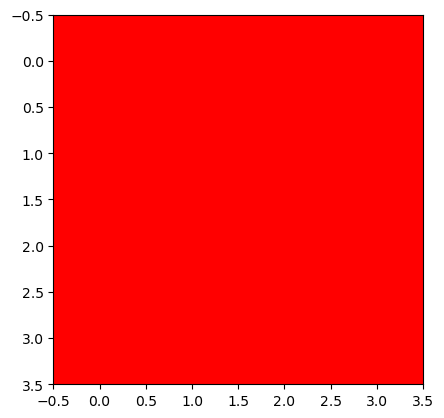

In [20]:
img_matplotlib = torch.stack([r, g, b], axis = -1) ## 최후방 축에 채널 배치
print(img_matplotlib)
print(img_matplotlib.shape)
plt.imshow(img_matplotlib)

`-` `img_pytorch`를 `plt.imshow`로 시각화

**잘못된 코드**

In [26]:
## 잘못된 코드
img_pytorch.squeeze().reshape(4, 4, 3) ## 쭉 편다음에 무지성으로 앞번호부터 먹임

tensor([[[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]],

        [[1., 1., 1.],
         [1., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]])

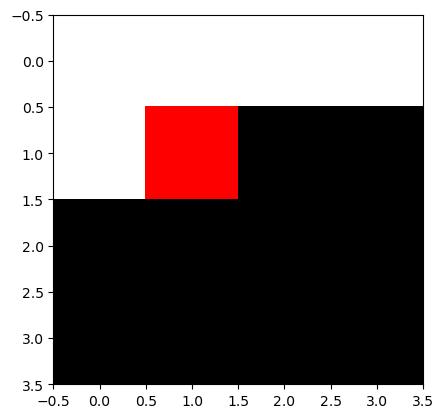

In [27]:
plt.imshow(img_pytorch.squeeze().reshape(4, 4, 3))

**올바른 코드**

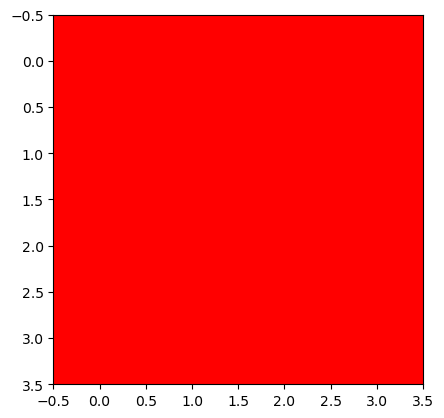

In [33]:
## 올바른 코드 1
plt.imshow(torch.einsum("ochw -> hwc", img_pytorch))
# plt.imshow(torch.einsum("chw -> hwc", img_pytorch.squeeze()))/

In [31]:
## 올바른 코드 2
img_pytorch.squeeze().permute(1, 2, 0) ## 축의 인덱스를 바꾸는 함수. chw 012 -> hwc 120

tensor([[[1., 0., 0.],
         [1., 0., 0.],
         [1., 0., 0.],
         [1., 0., 0.]],

        [[1., 0., 0.],
         [1., 0., 0.],
         [1., 0., 0.],
         [1., 0., 0.]],

        [[1., 0., 0.],
         [1., 0., 0.],
         [1., 0., 0.],
         [1., 0., 0.]],

        [[1., 0., 0.],
         [1., 0., 0.],
         [1., 0., 0.],
         [1., 0., 0.]]])

> 얘가 좀 쉽긴 함, `einsum`은 약간 뭐랄까 쿼리 같달까 -> 그래서 범용적임

## 4. 이미지 자료 처리

### **A. 데이터**

`-` 데이터 다운로드

In [3]:
train_dataset = torchvision.datasets.OxfordIIITPet(
    root='./data', 
    split='trainval',
    download=True,
    target_types='binary-category'
)
test_dataset = torchvision.datasets.OxfordIIITPet(
    root='./data', 
    split='test',
    download=True,
    target_types='binary-category'
)

100.0%
100.0%


* `train_dataset` : 3680개의 튜플

In [19]:
train_dataset[500]

(<PIL.Image.Image image mode=RGB size=500x334>, 1)

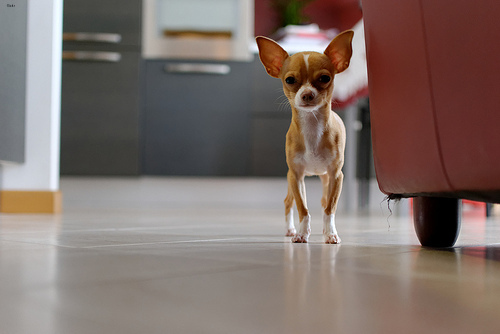

In [18]:
train_dataset[500][0]

> 고양이와 강아지 이미지 + 강아지를 분류하는 문제(강아지가 1로 인코딩)

* `test_dataset` : 3669개의 튜플

In [25]:
type(test_dataset)

torchvision.datasets.oxford_iiit_pet.OxfordIIITPet

In [26]:
type(test_dataset[0][0])

PIL.Image.Image

> 이미지로 아예 저장되어 있음 -> 분류를 위해서는 텐서로 변환할 필요가 있음

### **B. 이미지 변환**


`-` `x_pil`을 텐서로 바꿔보자

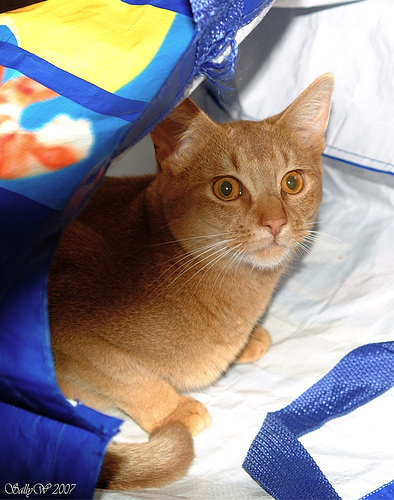

In [27]:
x_pil = train_dataset[0][0]
x_pil

`-` `PIL`을 텐서로 바꿔주는 클래스

In [30]:
to_tensor = torchvision.transforms.ToTensor()

In [34]:
x_tensor = to_tensor(x_pil)
x_tensor.shape

torch.Size([3, 500, 394])

잘 된 거 맞나?

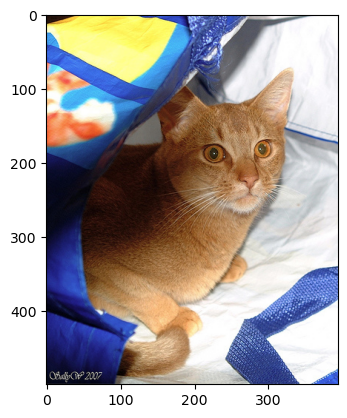

In [36]:
plt.imshow(x_tensor.permute(1, 2, 0)) ## 잘 됨

> 궁극적으로는 `train_dataset`의 모든 이미지를 `(3680, 3, h, w)`로 정리하여 `X`라고 하고 싶음... -> 이미지 크기를 통일시켜야 함... -> 이미지 크기를 통일시키는 방법을 찾아보자

`-` 이미지 크기 통일

In [37]:
## 이미지 크기를 통일시켜주는 클래스
resize = torchvision.transforms.Resize((512, 512))

In [38]:
to_tensor(resize(train_dataset[0][0])).shape

torch.Size([3, 512, 512])

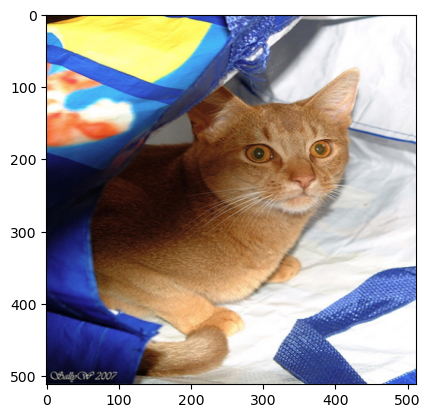

In [39]:
plt.imshow(to_tensor(resize(train_dataset[0][0])).permute(1, 2, 0))

> 그냥 옆으로 쭉 늘려놨네...

`-` 크기가 8인 이미지들의 배치를 만들기

In [44]:
# X = torch.stack([to_tensor(resize(train_dataset[i][0])) for i in range(3680)], axis = 0) ## 개오래걸림
Xm = torch.stack([to_tensor(resize(train_dataset[n][0])) for n in range(8)], axis = 0)
Xm.shape

torch.Size([8, 3, 512, 512])

In [48]:
## 8장의 이미지들이 들어가있는 하나의 배치가 만들어짐
[x.shape for x in Xm]

[torch.Size([3, 512, 512]),
 torch.Size([3, 512, 512]),
 torch.Size([3, 512, 512]),
 torch.Size([3, 512, 512]),
 torch.Size([3, 512, 512]),
 torch.Size([3, 512, 512]),
 torch.Size([3, 512, 512]),
 torch.Size([3, 512, 512])]

## 5. AP Layer

### **A. AP Layer**

> 채널별로 평균을 구하는 레이어

In [53]:
X = torch.arange(1*3*4*4).reshape(1, 3, 4, 4).float()
X

tensor([[[[ 0.,  1.,  2.,  3.],
          [ 4.,  5.,  6.,  7.],
          [ 8.,  9., 10., 11.],
          [12., 13., 14., 15.]],

         [[16., 17., 18., 19.],
          [20., 21., 22., 23.],
          [24., 25., 26., 27.],
          [28., 29., 30., 31.]],

         [[32., 33., 34., 35.],
          [36., 37., 38., 39.],
          [40., 41., 42., 43.],
          [44., 45., 46., 47.]]]])

In [54]:
ap = torch.nn.AdaptiveAvgPool2d(output_size = 1)

In [55]:
ap(X) ## 각 채널의 평균값이 들어감

tensor([[[[ 7.5000]],

         [[23.5000]],

         [[39.5000]]]])

In [61]:
## 이런것도 됨
# ap3 = torch.nn.AdaptiveAvgPool2d(output_size = (3, 3)) ## 한칸씩 중심을 옮겨서 하나봄?
# ap3(X)

### **B. AP, Linear의 교환**

In [62]:
r = X[:, 0, :, :]
g = X[:, 1, :, :]
b = X[:, 2, :, :]

`-` 신?기한 거

In [80]:
ap(r*0.1 + g*0.2 + b*0.3)

tensor([[[17.3000]]])

In [66]:
ap(r)*0.1 + ap(g)*0.2 + ap(b)*0.3

tensor([[[17.3000]]])

> 당연한 거

`-` 두 계산결과를 `torch.nn.AdaptiveAvgPool2d`, `torch.nn.Linear`, `torch.nn.Flatten`으로 구현

* 이거 구현

```Python
ap(r)*0.1 + ap(g)*0.2 + ap(b)*0.3
```

In [68]:
ap(X)

tensor([[[[ 7.5000]],

         [[23.5000]],

         [[39.5000]]]])

> 첫번째 거에 0.1 곱하고, 두번째에 0.2 곱하고, 세번째에 0.3 곱해서 더함

In [74]:
ap = torch.nn.AdaptiveAvgPool2d(output_size = 1)
flatten = torch.nn.Flatten() ## 펼쳐서 매트릭스 상 선형 변환이 가능하도록 만들고...
linr = torch.nn.Linear(3, 1, bias = False) ## 가중평균이라는 선형변환을 할거고...
linr.weight.data = torch.tensor([[0.1, 0.2, 0.3]]) ## 가중치를 조정할거고...

In [79]:
print(X.shape)
print(ap(X).shape) ## ap(r), ap(g), ap(b)
print(flatten(ap(X)).shape) ## ap(r), ap(g), ap(b)
print(linr(flatten(ap(X))).shape) ## ap(r)*0.1 + ap(g)*0.2 + ap(b)*0.3

torch.Size([1, 3, 4, 4])
torch.Size([1, 3, 1, 1])
torch.Size([1, 3])
torch.Size([1, 1])


* 이거 구현

```Python
ap(r*0.1 + g*0.2 + b*0.3)
```

> 먼저 각 채널의 값을 가중치로 해서 합하고, `ap`를 먹임
>
> `(1, 3, 4, 4), (1, 3) -> (1, 1, 4, 4)` + `ap`

In [94]:
ap = torch.nn.AdaptiveAvgPool2d(output_size = 1)
flatten = torch.nn.Flatten()
linr = torch.nn.Linear(3, 1, bias = False)
linr.weight.data = torch.tensor([[0.1, 0.2, 0.3]])

#---#
def _linr(X) :
    '''
    채널 별 가중합을 해주는 함수
    '''
    return torch.einsum("ochw, ij -> oihw", X, linr.weight.data)

#---#
print(X.shape)
print(_linr(X).shape) ## r*0.1 + g*0.2 + b*0.3
print(ap(_linr(X)).shape) ## ap(r*0.1 + g*0.2 + b*0.3)
print(flatten(ap(_linr(X))).shape)

torch.Size([1, 3, 4, 4])
torch.Size([1, 1, 4, 4])
torch.Size([1, 1, 1, 1])
torch.Size([1, 1])


## 6. CAM(Zhou et al. 2016)의 구현

ref: <https://arxiv.org/abs/1512.04150>

`-` 이 강의노트는 위의 논문의 내용을 재구성하였음.

### **A. 0단계 – (X,y), (XX,yy)**

In [2]:
train_dataset = torchvision.datasets.OxfordIIITPet(
    root='./data', 
    split='trainval',
    download=True,
    target_types='binary-category',
)
test_dataset = torchvision.datasets.OxfordIIITPet(
    root='./data', 
    split='test',
    download=True,
    target_types='binary-category',
)

In [3]:
## Sequential처럼 변환 클래스 연결
compose = torchvision.transforms.Compose([
    torchvision.transforms.Resize((512, 512)),
    torchvision.transforms.ToTensor()
])

In [4]:
X = torch.stack([compose(train_dataset[i][0]) for i in range(3680)], axis = 0)
XX = torch.stack([compose(test_dataset[i][0]) for i in range(3669)], axis = 0)
## 이진 분류니까 그냥 float으로 바꿔줌
y = torch.tensor([train_dataset[i][1] for i in range(3680)]).reshape(-1, 1).float()
yy = torch.tensor([test_dataset[i][1] for i in range(3669)]).reshape(-1, 1).float()

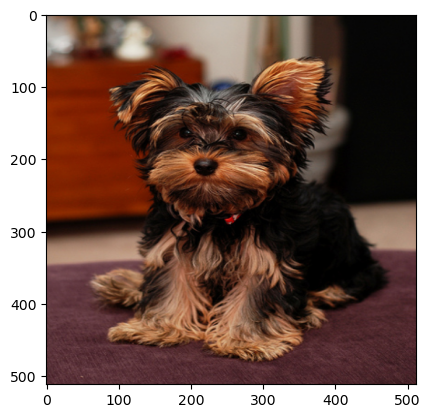

In [5]:
plt.imshow(X[-1].permute(1, 2, 0))

### **B. 1단계 - 이미지 분류 잘하는 네트워크 선택 후 학습**

In [65]:
torch.manual_seed(43052)

## step 1
ds_train = torch.utils.data.TensorDataset(X, y)
dl_train = torch.utils.data.DataLoader(ds_train, batch_size = 32, shuffle = True)

ds_test = torch.utils.data.TensorDataset(XX, yy)
dl_test = torch.utils.data.DataLoader(ds_test, batch_size = 32)

In [7]:
## step 2
resnet18 = torchvision.models.resnet18(pretrained = True)
resnet18.fc = torch.nn.Linear(512, 1)

loss_fn = torch.nn.BCEWithLogitsLoss()
optimizr = torch.optim.Adam(resnet18.parameters(), lr = 1e-5)

/root/anaconda3/envs/dl/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/root/anaconda3/envs/dl/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [8]:
## Step 3
resnet18.to("cuda:0")

for epoc in range(3) :
    resnet18.train()

    for Xm, ym in dl_train :
        Xm = Xm.to("cuda:0")
        ym = ym.to("cuda:0")

        netout = resnet18(Xm)
        loss = loss_fn(netout, ym)
        loss.backward()

        optimizr.step()
        optimizr.zero_grad()

    resnet18.eval()
    s = 0

    for Xm, ym in dl_train :
        Xm = Xm.to("cuda:0")
        ym = ym.to("cuda:0")

        s += ((resnet18(Xm) > 0) == ym).sum().item()

    acc = s/len(X)

    print(f"train_acc = {acc:.4f}")

train_acc = 0.9815
train_acc = 0.9973
train_acc = 0.9995


In [9]:
## step 4
s = 0

for XXm, yym in dl_test :
    XXm = XXm.to("cuda:0")
    yym = yym.to("cuda:0")

    s += ((resnet18(XXm) > 0) == yym).sum().item()

acc = s/len(XX)
print(f"test_acc = {acc:.4f}")

test_acc = 0.9951


### **C. 2단계 - `Linear`와 `AP`의 순서를 바꿈**

`-` `resnet18`을 재구성하여 `net`을 만들자

* resnet18은 결국 CNN이니까, 2d/1d 파트로 나뉠 것
* 인덱싱을 할 수 있도록 `torch.nn.Sequential` 객체로 먹임

In [66]:
x = X[[0]].to("cuda:0")

In [67]:
x.shape

torch.Size([1, 3, 512, 512])

In [68]:
net2d = torch.nn.Sequential(
    torch.nn.Sequential(
        resnet18.conv1,
        resnet18.bn1,
        resnet18.relu,
        resnet18.maxpool
    ),
    resnet18.layer1,
    resnet18.layer2,
    resnet18.layer3,
    resnet18.layer4
)

In [69]:
net2d(x).shape

torch.Size([1, 512, 16, 16])

In [70]:
net1d = torch.nn.Sequential(
    resnet18.avgpool,
    resnet18.fc
)

In [71]:
net = torch.nn.Sequential(
    net2d,
    net1d
)

In [72]:
# net1d(net2d(x)) ## error

In [73]:
net1d[0](net2d(x)).shape ## Flatten 어디감?

torch.Size([1, 512, 1, 1])

`-` 어떻게 되어있는지 파악 (`.forward`)

In [74]:
resnet18._forward_impl??

Signature: resnet18._forward_impl(x: torch.Tensor) -> torch.Tensor
Docstring: <no docstring>
Source:   
    def _forward_impl(self, x: Tensor) -> Tensor:
        # See note [TorchScript super()]
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x
File:      ~/anaconda3/envs/dl/lib/python3.9/site-packages/torchvision/models/resnet.py
Type:      method

In [75]:
torch.flatten(net1d[0](net2d(x)), 1).shape ## torch.nn.Flatten()과 동일한 기능

torch.Size([1, 512])

`-` 정리

In [76]:
stem = torch.nn.Sequential(
    torch.nn.Sequential(
        resnet18.conv1,
        resnet18.bn1,
        resnet18.relu,
        resnet18.maxpool
    ),
    resnet18.layer1,
    resnet18.layer2,
    resnet18.layer3,
    resnet18.layer4
)
head = torch.nn.Sequential(
    resnet18.avgpool,
    torch.nn.Flatten(), ## 얘를 추가해줘야 함. 왜 저렇게 설계했는지는 몰루?
    resnet18.fc
)
net = torch.nn.Sequential(
    stem,
    head
)

In [77]:
net(x), resnet18(x)

(tensor([[-5.5590]], device='cuda:0', grad_fn=<AddmmBackward0>),
 tensor([[-5.5590]], device='cuda:0', grad_fn=<AddmmBackward0>))

> 위와 같은 값 `-5.5590`이 나오는 과정을 추적하여 보자

`-` 계산방식 1 : 원래 계산방식

In [78]:
ap = head[0]
flatten = head[1]
linr = head[2]

#---#
print(f"{x.shape} -- x")
print(f"{stem(x).shape} -- stem(x)") ## 2d part가 16x16으로 정리됨
print(f"{ap(stem(x)).shape} -- ap(stem(x))") ## 이미지가 평균으로 풀링됨
print(f"{flatten(ap(stem(x))).shape} -- flatten(ap(stem(x)))") ## 뒤의 차원 없애줌
print(f"{linr(flatten(ap(stem(x)))).shape} -- linr(flatten(ap(stem(x))))") ## 최종 반환

torch.Size([1, 3, 512, 512]) -- x
torch.Size([1, 512, 16, 16]) -- stem(x)
torch.Size([1, 512, 1, 1]) -- ap(stem(x))
torch.Size([1, 512]) -- flatten(ap(stem(x)))
torch.Size([1, 1]) -- linr(flatten(ap(stem(x))))


**현재 네트워크**
$$\underset{(1,3,512,512)}{\boldsymbol x} \overset{stem}{\to} \left( \underset{(1,512,16,16)}{\tilde{\boldsymbol x}} \overset{ap}{\to} \underset{(1,512,1,1)}{{\boldsymbol \sharp}}\overset{flattn}{\to} \underset{(1,512)}{{\boldsymbol \sharp}}\overset{linr}{\to} \underset{(1,1)}{\text{logit}}\right) = [[-5.5613]]$$

**바꾸고 싶은 네트워크**
$$\underset{(1,3,224,224)}{\boldsymbol x} \overset{stem}{\to} \left( \underset{(1,512,16,16)}{\tilde{\boldsymbol x}} \overset{\_linr}{\to} \underset{(1,1,16,16)}{{\boldsymbol \sharp}}\overset{ap}{\to} \underset{(1,1,1,1)}{{\boldsymbol \sharp}}\overset{flattn}{\to} \underset{(1,1)}{\text{logit}}\right) = [[-5.5613]]$$

`-` 계산방식 2 : 순서를 바꿈

In [79]:
linr.weight.data.shape, x.shape

(torch.Size([1, 512]), torch.Size([1, 3, 512, 512]))

> `W@torch.flatten(x)`의 형태로 곱해줘야 함

In [90]:
ap = head[0]
flattn = head[1]
linr = head[2]

def _linr(x) :
    return torch.einsum("ochw, ic -> oihw", x, linr.weight.data) + linr.bias.data

#---#
print(f"{x.shape} -- x")
print(f"{stem(x).shape} -- stem(x)") ## 2d part가 16x16으로 정리됨
print(f"{_linr(stem(x)).shape} -- _linr(stem(x))") ## 채널 별 가중합
print(f"{ap(_linr(stem(x))).shape} -- ap(_linr(stem(x)))") ## 이미지 평균으로 풀링
print(f"{flatten(ap(_linr(stem(x)))).shape} -- flatten(ap(_linr(stem(x))))") ## flatten으로 포매팅

torch.Size([1, 3, 512, 512]) -- x
torch.Size([1, 512, 16, 16]) -- stem(x)
torch.Size([1, 1, 16, 16]) -- _linr(stem(x))
torch.Size([1, 1, 1, 1]) -- ap(_linr(stem(x)))
torch.Size([1, 1]) -- flatten(ap(_linr(stem(x))))


In [91]:
linr(flattn(ap(stem(x)))), flattn(ap(_linr(stem(x))))

(tensor([[-5.5590]], device='cuda:0', grad_fn=<AddmmBackward0>),
 tensor([[-5.5590]], device='cuda:0', grad_fn=<ViewBackward0>))

### $\star$ 잠깐 멈추고 생각 좀 해보자..

`-` 원래 계산방식을 적용

In [94]:
torch.sigmoid(resnet18(x))

tensor([[0.0038]], device='cuda:0', grad_fn=<SigmoidBackward0>)

In [98]:
torch.sigmoid(head(stem(x)))

tensor([[0.0038]], device='cuda:0', grad_fn=<SigmoidBackward0>)

In [99]:
linr(flattn(ap(stem(x))))

tensor([[-5.5590]], device='cuda:0', grad_fn=<AddmmBackward0>)

`-` 바뀐 계산방식을 적용

In [102]:
flattn(ap(_linr(stem(x))))

tensor([[-5.5590]], device='cuda:0', grad_fn=<ViewBackward0>)

`-` 바뀐 계산방식을 좀더 파고들어가보자

In [108]:
_linr(stem(x)).long() ## 정수로 먹임

tensor([[[[  0,   0,   0,   0,   0,   0,   0,   0,  -1,  -2,  -2,  -2,   0,   0,
             0,   0],
          [  0,   0,   0,   0,   0,   0,   0,  -1,   0,  -2,  -3,  -4,  -1,   0,
             0,   0],
          [  0,   0,   0,   1,   0,   0,   0,   0,   0,   0,  -3,  -5,  -4,  -2,
             0,   0],
          [  0,   0,   0,   0,   0,   0,   0,   0,  -1,  -4,  -9, -12, -12,  -8,
            -2,   0],
          [  0,   0,   0,   0,   0,   0,  -1,  -5, -11, -16, -20, -24, -22, -14,
            -4,   0],
          [ -1,  -1,   0,   0,   0,   0,  -5, -16, -28, -35, -40, -43, -38, -23,
            -7,   0],
          [ -1,  -1,   0,   0,   0,   0, -10, -28, -47, -56, -56, -53, -43, -25,
            -7,   0],
          [  0,  -1,   0,   0,   0,   0, -11, -29, -49, -57, -54, -47, -34, -19,
            -4,   1],
          [  0,   0,   0,   0,   0,   0,  -7, -21, -36, -43, -38, -29, -18,  -8,
            -1,   0],
          [  0,   0,  -1,  -1,   0,   0,  -3,  -9, -16, -19, -16, -11,  -

> 여러 값들이 있지만, 아무튼 이 값들의 평균은 `-5.5590`임 -> 작을수록 이 그림은 고양이
>
> 그런데 대부분의 위치에선 0에 가까운 값을 가지고, 특정 위치에서는 엄청 작은 값이 존재해서 평균값이 음수가 나오는 거임
>
> **즉, 이 특정위치에 존재하는 엄청 작은 값들이 `x`가 고양이라고 판단하는 근거가 됨**

`-` 바꾸고 싶은 네트워크 - `why`라는 이름을 적용 -> 왜 그렇게 판단했는지에 대한 지표

In [109]:
why = _linr(stem(x))

$$\underset{(1,3,224,224)}{\boldsymbol x} \overset{stem}{\to} \left( \underset{(1,512,16,16)}{\tilde{\boldsymbol x}} \overset{\_linr}{\to} \underset{(1,1,16,16)}{\bf why}\overset{ap}{\to} \underset{(1,1,1,1)}{{\boldsymbol \sharp}}\overset{flattn}{\to} \underset{(1,1)}{logit}\right) = [[-5.5613]]$$

### **D. 3단계 - WHY 시각화**

`#` 시각화 1 - `why`와 `img`를 겹쳐서 그려보자

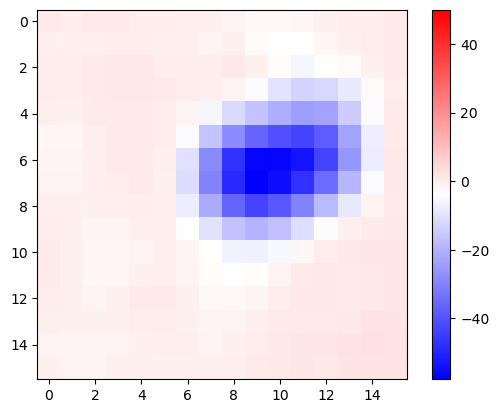

In [125]:
plt.imshow(why.squeeze().cpu().data, cmap = "bwr", vmax = 50)
plt.colorbar()

In [140]:
why_resized.abs().max()

tensor(57.6904, device='cuda:0', grad_fn=<MaxBackward1>)

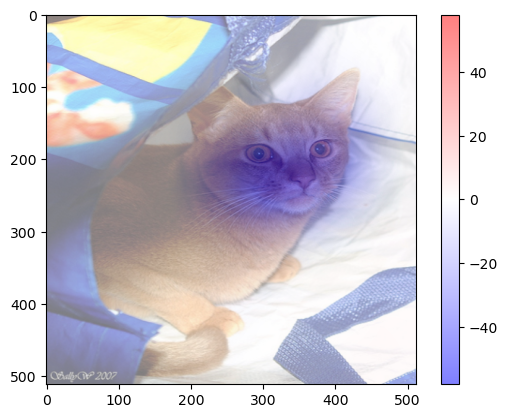

In [142]:
plt.imshow(x.cpu().squeeze().permute(1, 2, 0))

## torchvision.transforms.Resize() ## ...
why_resized = torch.nn.functional.interpolate(
    why, size = (512, 512), mode = "bilinear"
)

plt.imshow(why_resized.squeeze().cpu().data, cmap = "bwr", alpha = 0.5, vmax = 58, vmin = -58)
plt.colorbar()
plt.show()

`#` 시각화 2 - colormap을 `magma`로 적용

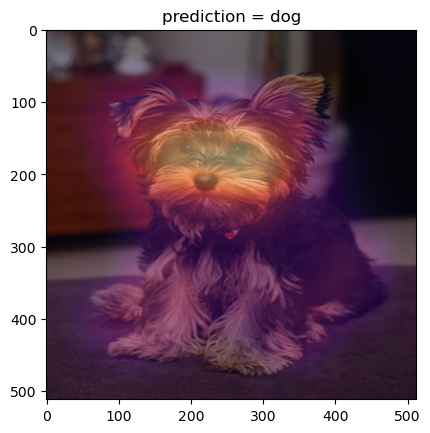

In [151]:
x = X[[-1]].to("cuda:0")

## 색상을 동일하게 만들어서 판단 지표 시각화 일관성 확보
if net(x) > 0 :
    pred = "dog"
    why = _linr(stem(x))
else :
    pred = "cat"
    why = - _linr(stem(x))

why = _linr(stem(x))
why_resized = torch.nn.functional.interpolate(
    why, size = (512, 512), mode = "bilinear"
)

plt.imshow(x.squeeze().cpu().data.permute(1, 2, 0))
plt.imshow(why_resized.squeeze().cpu().data, cmap = "magma", alpha = 0.5)
plt.title(f"prediction = {pred}")
plt.show()

`#` 시각화 3 - 새로운 이미지 : 하니를 시각화해보자

In [152]:
url = 'https://github.com/guebin/DL2025/blob/main/imgs/hani1.jpeg?raw=true'
hani_pil = PIL.Image.open(
    io.BytesIO(requests.get(url).content)
)

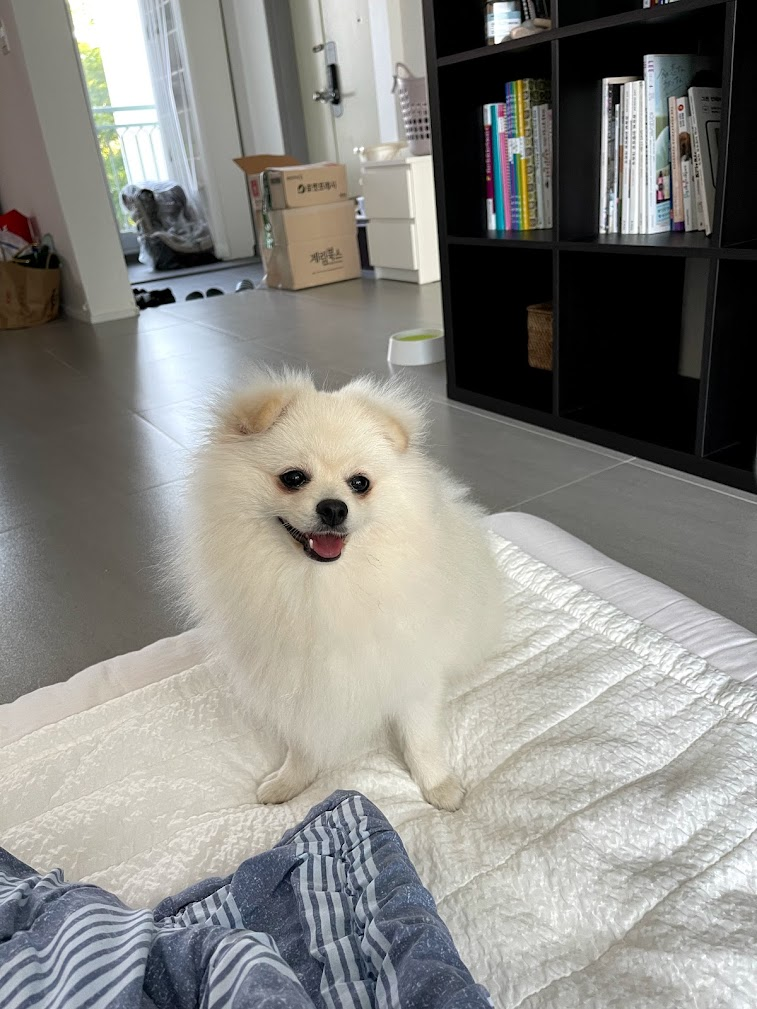

In [153]:
hani_pil

In [155]:
# torchvision.transforms.Compose(
#     torchvision.transforms.Resize((512, 512)),
#     torchvision.transforms.ToTensor()
# )

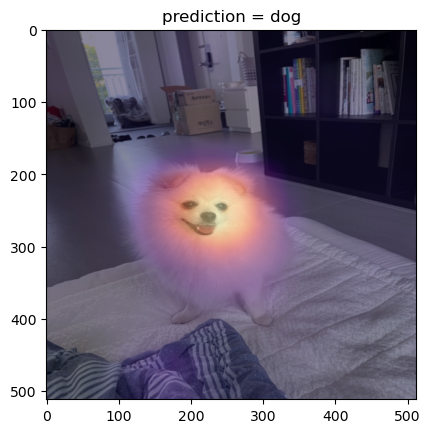

In [162]:
x = compose(hani_pil).reshape(1, 3, 512, 512).to("cuda:0")

if net(x) > 0 :
    pred = "dog"
    why = _linr(stem(x))

else :
    pred = "cat"
    why = - _linr(stem(x))

why_resized = torch.nn.functional.interpolate(
    why, size = (512, 512), mode = "bilinear"
)

plt.imshow(x.squeeze().cpu().data.permute(1, 2, 0))
plt.imshow(why_resized.squeeze().cpu().data, cmap = "magma", alpha = 0.5)
plt.title(f"prediction = {pred}");

`#` 시각화 4 - `XX`의 이미지 시각화

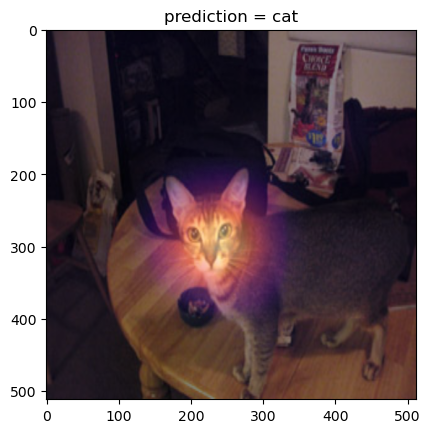

In [164]:
x = XX[[0]].to("cuda:0")

if net(x) > 0 :
    pred = "dog"
    why = _linr(stem(x))

else :
    pred = "cat"
    why = - _linr(stem(x))

why_resized = torch.nn.functional.interpolate(
    why, size = (512, 512), mode = "bilinear"
)

plt.imshow(x.squeeze().cpu().data.permute(1, 2, 0))
plt.imshow(why_resized.squeeze().cpu().data, cmap = "magma", alpha = 0.5)
plt.title(f"prediction = {pred}");

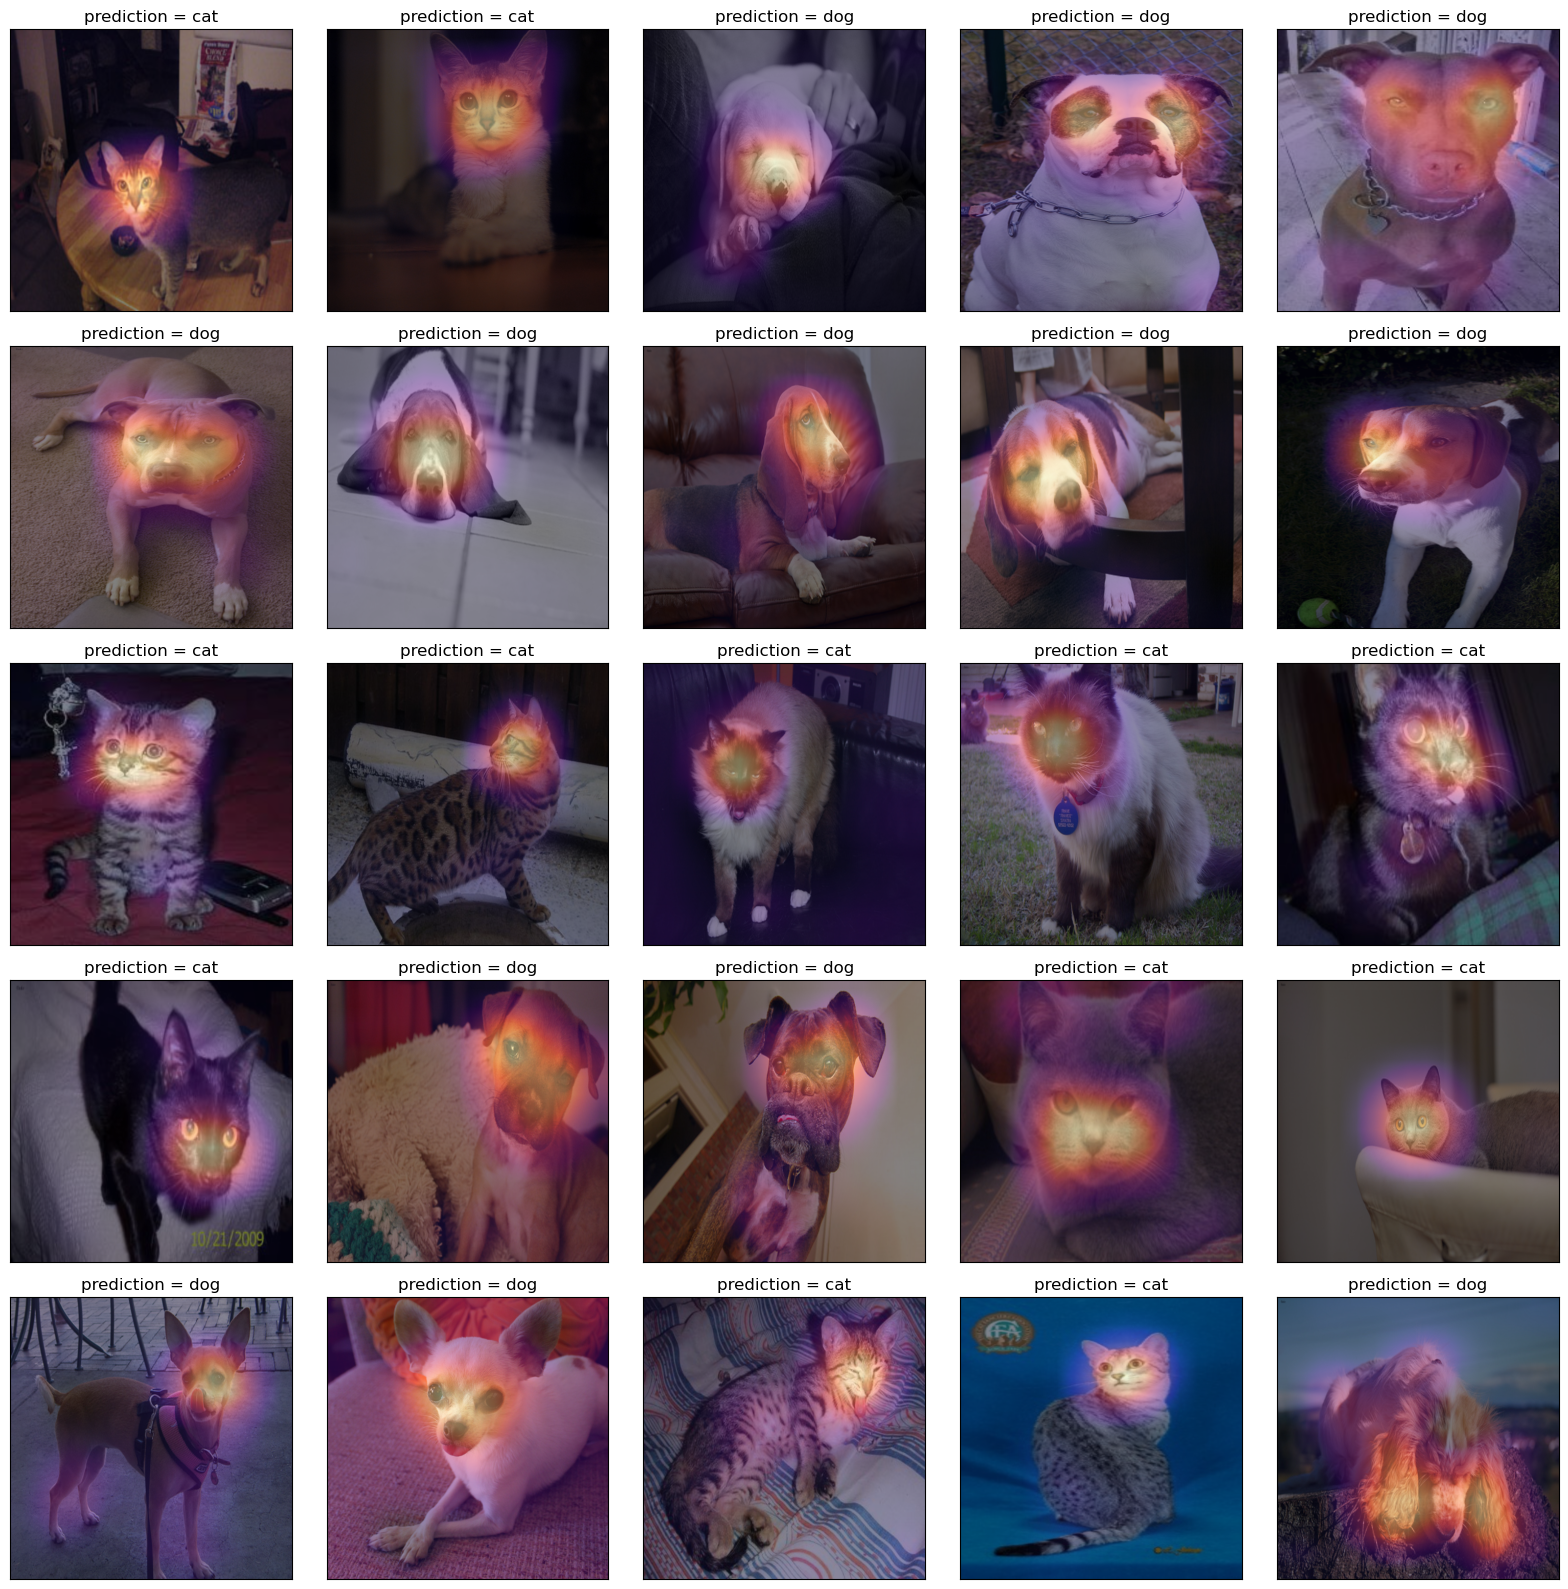

In [169]:
fig, ax = plt.subplots(5, 5)

#---#
k = 0

for i in range(5) :
    for j in range(5) :
        x = XX[[k]].to("cuda:0")

        if net(x) > 0 :
            pred = "dog"
            why = _linr(stem(x))
        
        else :
            pred = "cat"
            why = - _linr(stem(x))
        
        why_resized = torch.nn.functional.interpolate(
            why, size = (512, 512), mode = "bilinear"
        )

        ax[i][j].imshow(x.squeeze().cpu().data.permute(1, 2, 0))
        ax[i][j].imshow(why_resized.squeeze().cpu().data, cmap = "magma", alpha = 0.5)
        ax[i][j].set_title(f"prediction = {pred}");
        ax[i][j].set_xticks([])
        ax[i][j].set_yticks([])
        
        k += 50

fig.set_figheight(16)
fig.set_figwidth(16)
fig.tight_layout()

> AI의 판단근거를 설명할 수 있다면... 사람들이 좀더 받아들이기 편하겠지...

## 7. CAM의 한계

**핵심 아이디어**

* `ap`와 `linr`를 바꿀 수 있다 -> `resnet`의 경우 뒤에 `ap`와 `linr`가 순서대로 놓여있으니 가능...

> 하지만 다른 구조를 가지는 경우???

In [170]:
torchvision.models.AlexNet()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

> 얘는 `ap` 다음에 신경망을 넣어놨기 때문에 두 개를 바꾸는 것이 불가능함...
>
> CAM을 하기 위해선 그냥 뒤의 신경망 부분을 없애버리고 -> 단순 선형 변환으로 바꿔줘야 함 -> 근데 그렇다고 성능이 그렇게 떨어지지는 않음

`-` 구조의 제약이 있음

* `head-part`가 `ap + linr`로만 구성되어야 가능
* 그렇지 않은 네트워크는 임의로 재구성하여 `head-part`를 `ap + linr`로만 구성되게 만듦 -> CAM 적용
* 제약이 있다고 깎아내리기에는 너무 큰 영향력을 미친 논문...

`-` 이후 개선된 `grad-cam`의 경우 구조적인 제약없이 거의 모든 CNN에 적용 가능